# Persiapan Library

In [1]:
import torch, time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
if torch.cuda.is_available():
    print("Device:",torch.cuda.current_device())
    print("Device Name:",torch.cuda.get_device_name())

Device: 0
Device Name: Tesla T4


# Preprocessing

In [3]:
img_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomVerticalFlip(0.3),
    transforms.Resize((240,240)),
    transforms.CenterCrop((240,240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
img_transforms

Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.4)
    RandomVerticalFlip(p=0.3)
    Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(240, 240))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
data_dir = "/content/drive/MyDrive/weavisproject/dataset"
dataset = datasets.ImageFolder(root=data_dir,transform=img_transforms)

In [5]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [6]:
len(dataset)

4250

In [7]:
train_set, test_set = random_split(dataset=dataset,lengths=[0.8,0.2])

In [8]:
train_loader = DataLoader(dataset=train_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
test_loader = DataLoader(dataset=test_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")

In [9]:
for images, labels in train_loader:
    break

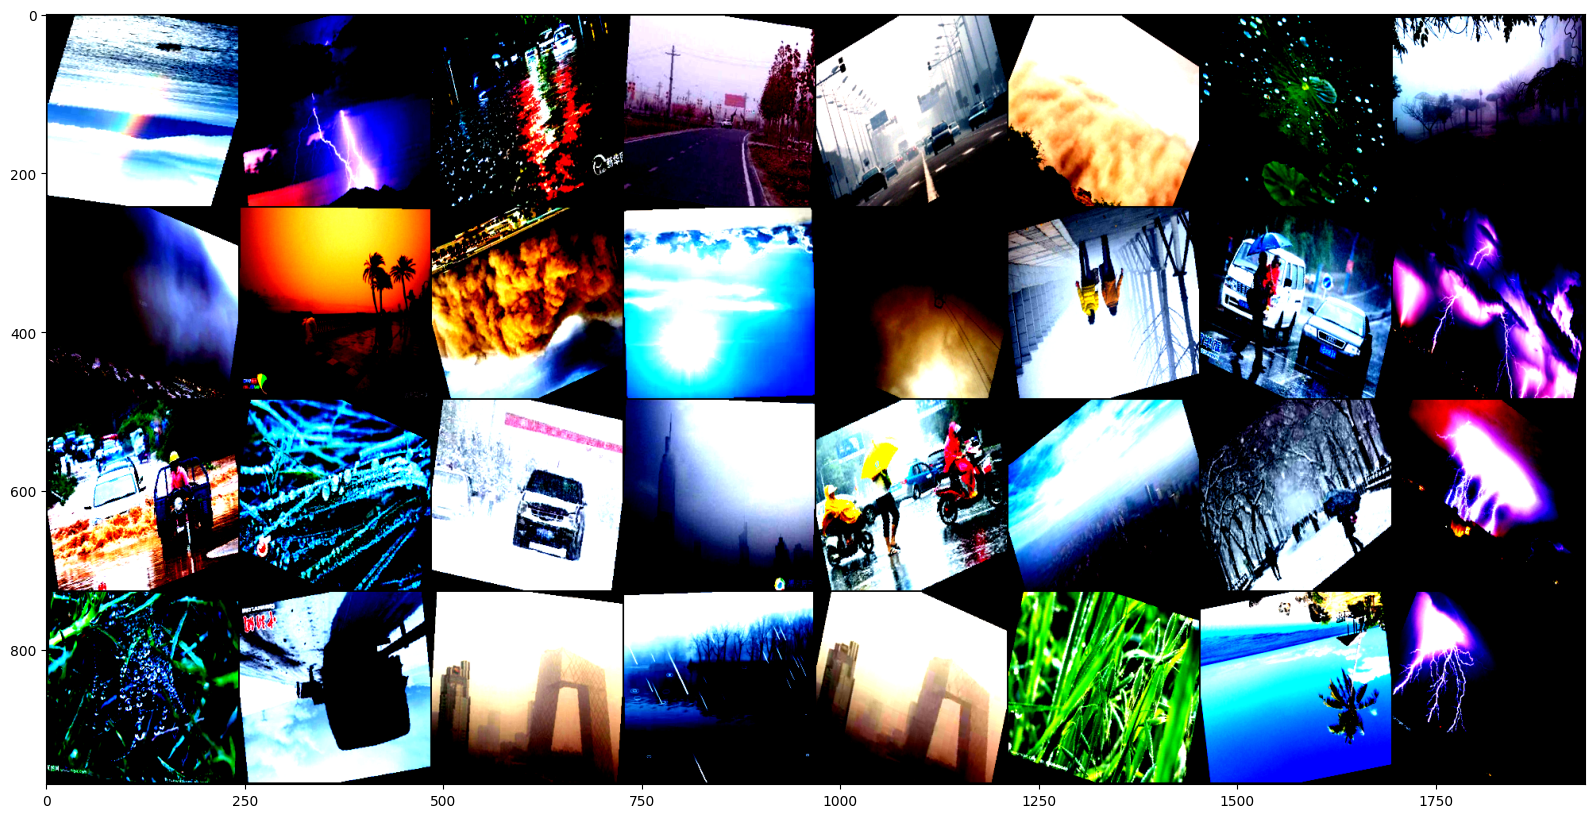

In [10]:
img_grid = make_grid(images,nrow=8)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_images = inv_normalize(images)

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(img_grid.numpy(),(1,2,0)));

In [11]:
images.shape

torch.Size([32, 3, 240, 240])

# Training Model

In [12]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1)
        self.fc1 = nn.Linear(in_features=13*13*512,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=256)
        self.fc3 = nn.Linear(in_features=256,out_features=128)
        self.fc4 = nn.Linear(in_features=128,out_features=64)
        self.fc5 = nn.Linear(in_features=64,out_features=32)
        self.fc6 = nn.Linear(in_features=32,out_features=8)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,13*13*512)
        X = F.relu(self.fc1(X))
        X = F.dropout(X,p=0.45)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,p=0.35)
        X = F.relu(self.fc3(X))
        X = F.dropout(X,p=0.25)
        X = F.relu(self.fc4(X))
        X = F.dropout(X,p=0.2)
        X = F.relu(self.fc5(X))
        X = F.dropout(X,p=0.1)
        X = self.fc6(X)
        return F.log_softmax(X,dim=1)

In [13]:
torch.manual_seed(48)
model = CNN().cuda()
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=8, bias=True)
)

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 46028648


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)

In [16]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = model(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 1.7955496311187744
Epoch 1 Batch 100 -> Loss: 1.4560929536819458
Epoch 2 Batch 50 -> Loss: 1.7526543140411377
Epoch 2 Batch 100 -> Loss: 1.4819831848144531
Epoch 3 Batch 50 -> Loss: 1.3002760410308838
Epoch 3 Batch 100 -> Loss: 0.9677134156227112
Epoch 4 Batch 50 -> Loss: 0.7983818054199219
Epoch 4 Batch 100 -> Loss: 1.2544593811035156
Epoch 5 Batch 50 -> Loss: 1.1013144254684448
Epoch 5 Batch 100 -> Loss: 1.1324046850204468
Epoch 6 Batch 50 -> Loss: 1.2564146518707275
Epoch 6 Batch 100 -> Loss: 1.189934253692627
Epoch 7 Batch 50 -> Loss: 1.335581660270691
Epoch 7 Batch 100 -> Loss: 1.4090421199798584
Epoch 8 Batch 50 -> Loss: 1.1712819337844849
Epoch 8 Batch 100 -> Loss: 0.908906102180481
Epoch 9 Batch 50 -> Loss: 0.8757290244102478
Epoch 9 Batch 100 -> Loss: 0.8615535497665405
Epoch 10 Batch 50 -> Loss: 1.1556875705718994
Epoch 10 Batch 100 -> Loss: 0.9142125248908997
Epoch 11 Batch 50 -> Loss: 0.9628716707229614
Epoch 11 Batch 100 -> Loss: 0.931603550910949

# Evaluasi Model

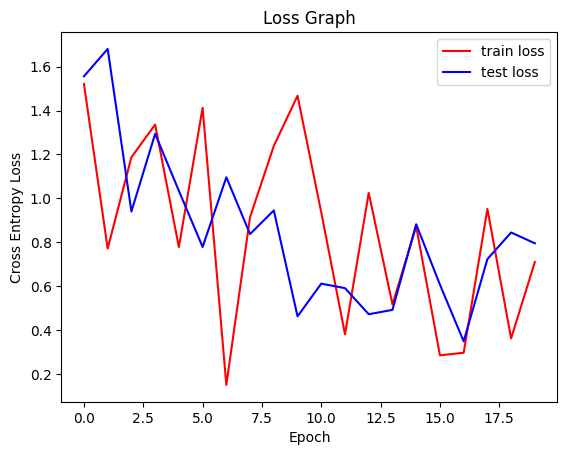

In [17]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

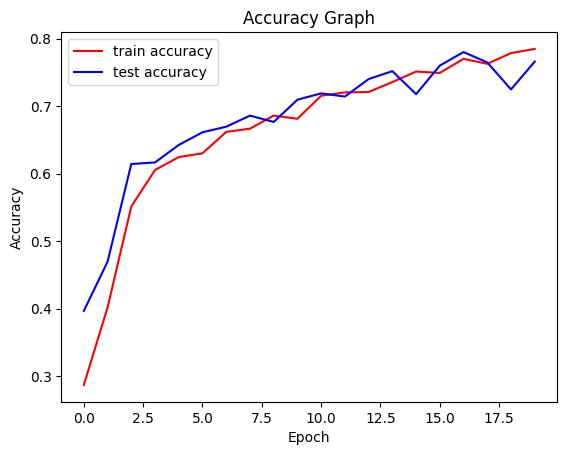

In [18]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

# Fine-Tunning Dengan ResNet50

In [19]:
resnet = models.resnet50(pretrained=True)
resnet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
total_params = 0

for param in resnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of pretrained ResNet50 model:", total_params)

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
524288
512
512
2359296
512
512
1048576
2048
2048
2097152
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
2048000
1000
Total parameters of pretrained ResNet50 model: 25557032


In [21]:
resnet.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,8),
    nn.LogSoftmax(dim=1)
)
resnet = resnet.cuda()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=resnet.parameters(),lr=0.001)

In [23]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = resnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = resnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 0.5463179349899292
Epoch 1 Batch 100 -> Loss: 0.4362894594669342
Epoch 2 Batch 50 -> Loss: 0.36911314725875854
Epoch 2 Batch 100 -> Loss: 0.3988209664821625
Epoch 3 Batch 50 -> Loss: 0.3158497214317322
Epoch 3 Batch 100 -> Loss: 0.4386419355869293
Epoch 4 Batch 50 -> Loss: 0.14921101927757263
Epoch 4 Batch 100 -> Loss: 0.15165074169635773
Epoch 5 Batch 50 -> Loss: 0.5326787829399109
Epoch 5 Batch 100 -> Loss: 0.2637505531311035
Epoch 6 Batch 50 -> Loss: 0.3636363744735718
Epoch 6 Batch 100 -> Loss: 0.25567951798439026
Epoch 7 Batch 50 -> Loss: 0.24556268751621246
Epoch 7 Batch 100 -> Loss: 0.21954864263534546
Epoch 8 Batch 50 -> Loss: 0.19028505682945251
Epoch 8 Batch 100 -> Loss: 0.3234045207500458
Epoch 9 Batch 50 -> Loss: 0.15737177431583405
Epoch 9 Batch 100 -> Loss: 0.17353668808937073
Epoch 10 Batch 50 -> Loss: 0.4563382863998413
Epoch 10 Batch 100 -> Loss: 0.46891865134239197
Epoch 11 Batch 50 -> Loss: 0.180364727973938
Epoch 11 Batch 100 -> Loss: 0.259

**Evaluasi Loss**

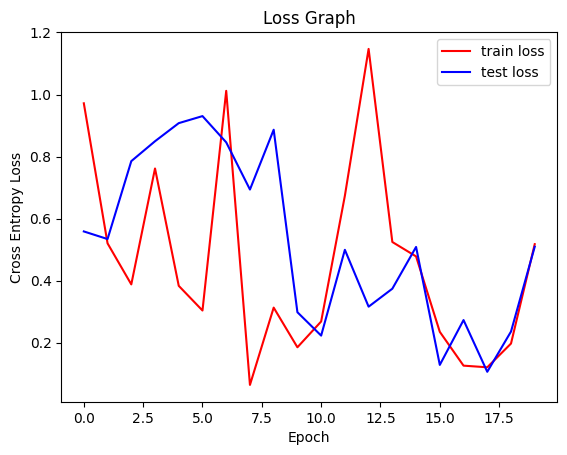

In [24]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

**Evaluasi Akurasi**

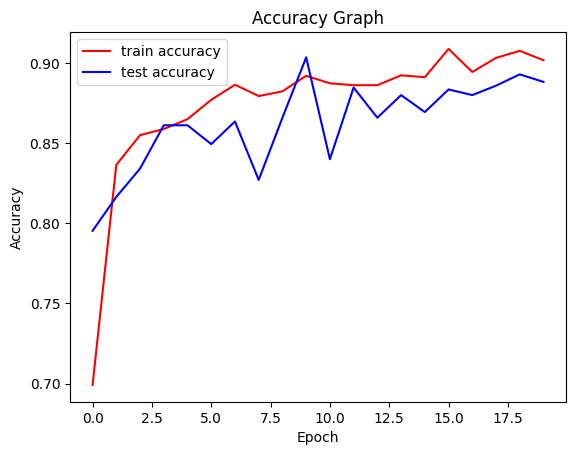

In [25]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

# Fine-Tunning Dengan AlexNet

In [26]:
alexnet = models.alexnet(pretrained=True)
alexnet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 172MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
total_params = 0

for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of the AlexNet model:", total_params)

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000
Total parameters of the AlexNet model: 61100840


In [28]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,8),
    nn.LogSoftmax(dim=1)
)
alexnet = alexnet.cuda()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=alexnet.parameters(),lr=0.001)

In [30]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = alexnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 1.1328847408294678
Epoch 1 Batch 100 -> Loss: 0.4942243993282318
Epoch 2 Batch 50 -> Loss: 0.36495673656463623
Epoch 2 Batch 100 -> Loss: 0.5562063455581665
Epoch 3 Batch 50 -> Loss: 0.5061532855033875
Epoch 3 Batch 100 -> Loss: 0.3827151358127594
Epoch 4 Batch 50 -> Loss: 0.41561317443847656
Epoch 4 Batch 100 -> Loss: 0.14995139837265015
Epoch 5 Batch 50 -> Loss: 0.7976164817810059
Epoch 5 Batch 100 -> Loss: 0.25093919038772583
Epoch 6 Batch 50 -> Loss: 0.1804204285144806
Epoch 6 Batch 100 -> Loss: 0.4453614354133606
Epoch 7 Batch 50 -> Loss: 0.30021825432777405
Epoch 7 Batch 100 -> Loss: 0.08950597792863846
Epoch 8 Batch 50 -> Loss: 0.8588773608207703
Epoch 8 Batch 100 -> Loss: 0.3217191696166992
Epoch 9 Batch 50 -> Loss: 0.11835343390703201
Epoch 9 Batch 100 -> Loss: 0.529033899307251
Epoch 10 Batch 50 -> Loss: 0.29996830224990845
Epoch 10 Batch 100 -> Loss: 0.18528376519680023
Epoch 11 Batch 50 -> Loss: 0.3071483373641968
Epoch 11 Batch 100 -> Loss: 0.5940

**Evaluasi Loss**

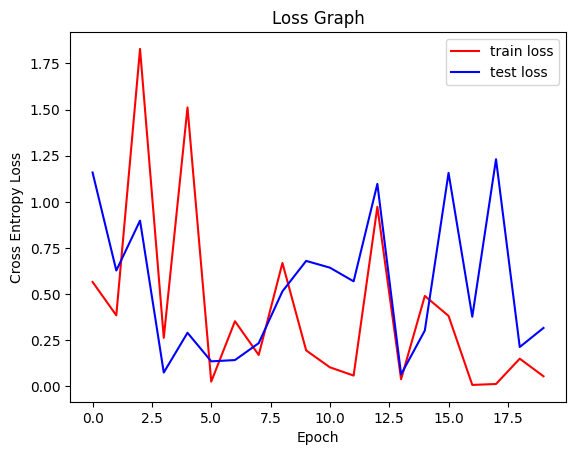

In [31]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

**Evaluasi Akurasi**

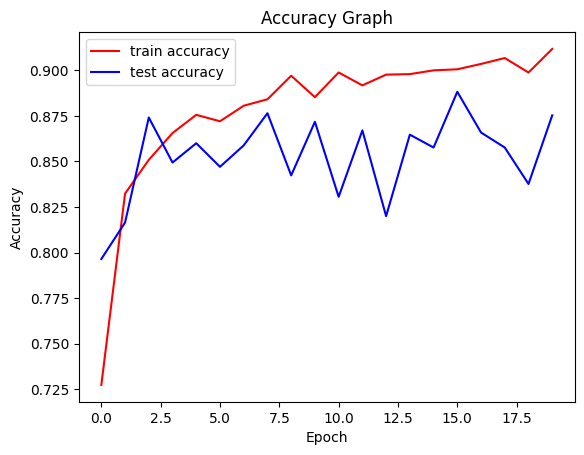

In [32]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

# Fine-Tunning Dengan VGG16

In [33]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 176MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
total_params = 0

for param in vgg16.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of the pretrained VGG16 model:", total_params)

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000
Total parameters of the pretrained VGG16 model: 138357544


In [35]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(1024,8),
    nn.LogSoftmax(dim=1)
)

vgg16 = vgg16.cuda()
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=vgg16.parameters(),lr=0.001)

In [37]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = vgg16(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = vgg16(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 0.8376426696777344
Epoch 1 Batch 100 -> Loss: 1.142861008644104
Epoch 2 Batch 50 -> Loss: 0.14794333279132843
Epoch 2 Batch 100 -> Loss: 0.8046819567680359
Epoch 3 Batch 50 -> Loss: 0.8543974757194519
Epoch 3 Batch 100 -> Loss: 0.35324007272720337
Epoch 4 Batch 50 -> Loss: 0.2889099717140198
Epoch 4 Batch 100 -> Loss: 0.9276431798934937
Epoch 5 Batch 50 -> Loss: 0.4764474332332611
Epoch 5 Batch 100 -> Loss: 0.4389136731624603
Epoch 6 Batch 50 -> Loss: 0.19428376853466034
Epoch 6 Batch 100 -> Loss: 0.2034371793270111
Epoch 7 Batch 50 -> Loss: 0.4802568256855011
Epoch 7 Batch 100 -> Loss: 0.24467690289020538
Epoch 8 Batch 50 -> Loss: 0.27748727798461914
Epoch 8 Batch 100 -> Loss: 0.19676201045513153
Epoch 9 Batch 50 -> Loss: 0.5366037487983704
Epoch 9 Batch 100 -> Loss: 0.22859632968902588
Epoch 10 Batch 50 -> Loss: 0.2612513303756714
Epoch 10 Batch 100 -> Loss: 0.2663191556930542
Epoch 11 Batch 50 -> Loss: 0.5385206937789917
Epoch 11 Batch 100 -> Loss: 0.160169

**Evaluasi Loss**

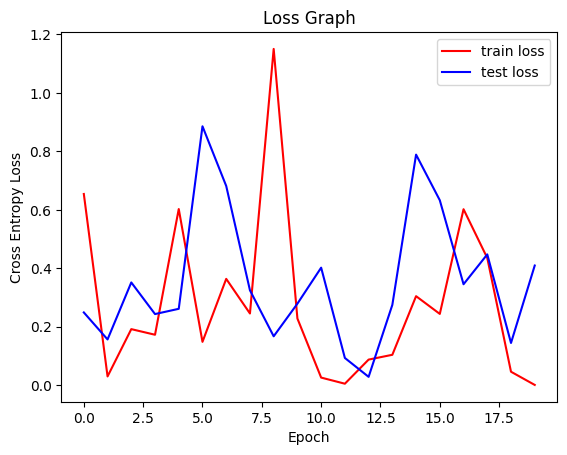

In [38]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

**Evaluasi Akurasi**

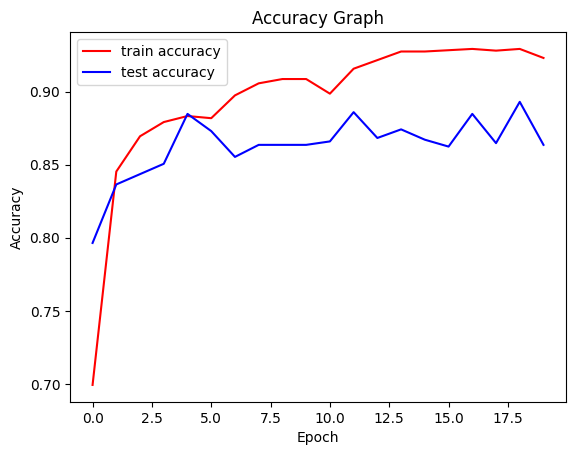

In [39]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

# Fine-Tunning Dengan MobileNet v3 Large

In [40]:
mobilenet = models.mobilenet_v3_large(pretrained=True)
mobilenet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 149MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [41]:
total_params = 0

for param in mobilenet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of Mobile Net v3 Large model:", total_params)

432
16
16
144
16
16
256
16
16
1024
64
64
576
64
64
1536
24
24
1728
72
72
648
72
72
1728
24
24
1728
72
72
1800
72
72
1728
24
1728
72
2880
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
9600
240
240
2160
240
240
19200
80
80
16000
200
200
1800
200
200
16000
80
80
14720
184
184
1656
184
184
14720
80
80
14720
184
184
1656
184
184
14720
80
80
38400
480
480
4320
480
480
57600
120
57600
480
53760
112
112
75264
672
672
6048
672
672
112896
168
112896
672
75264
112
112
75264
672
672
16800
672
672
112896
168
112896
672
107520
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
1228800
1280
1280000
1000
Total parameters of Mobile Net v3 Large model: 5483032


In [42]:
mobilenet.classifier = nn.Sequential(
    nn.Linear(960,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,8),
    nn.LogSoftmax(dim=1)
)

mobilenet = mobilenet.cuda()
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=mobilenet.parameters(),lr=0.001)

In [44]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = mobilenet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = mobilenet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 0.7631399631500244
Epoch 1 Batch 100 -> Loss: 0.2917378544807434
Epoch 2 Batch 50 -> Loss: 0.1896832436323166
Epoch 2 Batch 100 -> Loss: 0.4791387617588043
Epoch 3 Batch 50 -> Loss: 0.4860134422779083
Epoch 3 Batch 100 -> Loss: 0.4924807846546173
Epoch 4 Batch 50 -> Loss: 0.24801123142242432
Epoch 4 Batch 100 -> Loss: 0.5176854133605957
Epoch 5 Batch 50 -> Loss: 0.17132005095481873
Epoch 5 Batch 100 -> Loss: 0.8032211661338806
Epoch 6 Batch 50 -> Loss: 0.40285441279411316
Epoch 6 Batch 100 -> Loss: 0.6135108470916748
Epoch 7 Batch 50 -> Loss: 0.12028433382511139
Epoch 7 Batch 100 -> Loss: 0.08586660027503967
Epoch 8 Batch 50 -> Loss: 0.33399784564971924
Epoch 8 Batch 100 -> Loss: 0.31761330366134644
Epoch 9 Batch 50 -> Loss: 0.17024442553520203
Epoch 9 Batch 100 -> Loss: 0.20307525992393494
Epoch 10 Batch 50 -> Loss: 0.43430671095848083
Epoch 10 Batch 100 -> Loss: 0.3263721466064453
Epoch 11 Batch 50 -> Loss: 0.3065459430217743
Epoch 11 Batch 100 -> Loss: 0.28

**Evaluasi Loss**

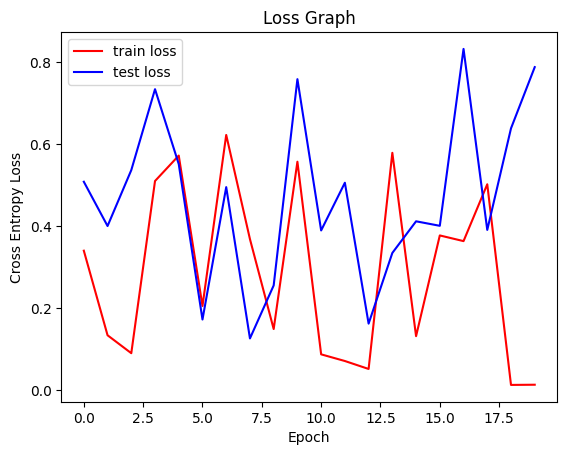

In [45]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

**Evaluasi Akurasi**

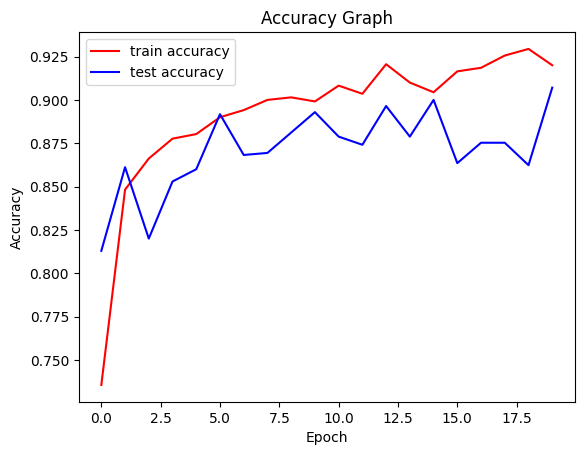

In [46]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [50]:
print(f"Akurasi Training Tertinggi: {max(train_accuracies):.2f}")
print(f"Akurasi Testing Tertinggi: {max(test_accuracies):.2f}")

Akurasi Training Tertinggi: 0.93
Akurasi Testing Tertinggi: 0.91


# Menyimpan Model

**Model CNN Based**

In [51]:
torch.save(model,'weavis_cnn_based_model.pt')

In [52]:
from google.colab import files
files.download('weavis_cnn_based_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model ResNet50**

In [53]:
torch.save(resnet,'weavis_resnet50_model.pt')

In [54]:
from google.colab import files
files.download('weavis_resnet50_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model AlexNet**

In [55]:
torch.save(alexnet,'weavis_alexnet_model.pt')

In [56]:
from google.colab import files
files.download('weavis_alexnet_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model VGG16**

In [57]:
torch.save(vgg16,'weavis_vgg16_model.pt')

In [58]:
from google.colab import files
files.download('weavis_vgg16_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model MobileNet v3 Large**

In [59]:
torch.save(mobilenet,'weavis_mobilenetv3_large_model.pt')

In [60]:
from google.colab import files
files.download('weavis_mobilenetv3_large_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>